<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/Midterm_2019a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm exam
$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> EE370: Software lab, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_

---
## Handwritten image classifier

In this problem, we will develop a simple handwritten image classfier, that

- receives a grayscale $m \times m$ handwritten image of a digit (0~9) as input,
- and tells what it is.

Cool... This problem will hopefully guide you step-by-step through the development and training procedures for a simple classifier.

The following cell downloads a data set that contains 10,000 handwritten images ($n=10000$) with correct label for each image. Each image is made of 28x28 grayscale pixels ($m=28$) and the label is given by an integer from 0 to 9, so we represents the $n$-th data pair by $X^{(n)}\in\R^{m\times m}$ (image) and $y^{(n)} \in \{0,1,\dots,9\}$ (label).

We will use some of these data pairs to train our model. The model is simply a python function, that receives an $m\times m$ grayscale image as input and returns what the input image looks closest among the integers from 0 to 9. What we mean by "to train" is to find appropriate parameters of the model function based on the data pairs that we use for training.

Note that $X^{(n)}\in\R^{m\times m}$ and $y^{(n)}$ are accessible by `X[:,:,n]` and `y[n]` below.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('https://jonghank.github.io/ee370/files/numbers.csv', \
                 header=None).values

m = 28     # 28x28: image size
K = 10     # 10: each image represents one of 10 digits
N = 10000  # 10000: number of images in the train set

y = data[:,0]
X = np.zeros((m,m,N))
for n in range(N):
  X[:,:,n] = data[n,1:].reshape((m,m))

print(X.shape, y.shape)

(28, 28, 10000) (10000,)


<br>

For example, the first 12 images and the labels from the dataset are shown below. You can check if they coincide.

First 12 images:



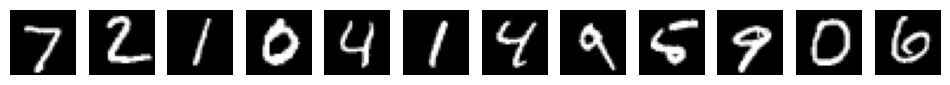

First 12 label:
[7 2 1 0 4 1 4 9 5 9 0 6]


In [2]:
n_examples = 12
print(f'First {n_examples} images:\n')
plt.figure(figsize=(12,4), dpi=100)
for n in range(n_examples):
  plt.subplot(1,n_examples,n+1)
  plt.imshow(X[:,:,n], cmap='gray')
  plt.axis('off')
plt.show()

print(f'First {n_examples} label:\n{y[:n_examples]}')

<br>

_**(Problem 1a)**_ We will first split the data by the "Train set" and the "Validation set". The train set is something we use for training the classifier, and the validation set is something we use for evaluating the accuracy of the classifier.

Simply let the first 7,000 data pairs ($n_\text{train}=7000$) be the train set ($X_\text{train}$ and $y_\text{train}$) and the rest 3,000 ($n_\text{valid}=3000$) be the validation set ($X_\text{valid}$ and $y_\text{valid}$).

Display the first 12 images from the validation set.

In [6]:
display(y)

array([7, 2, 1, ..., 4, 5, 6])

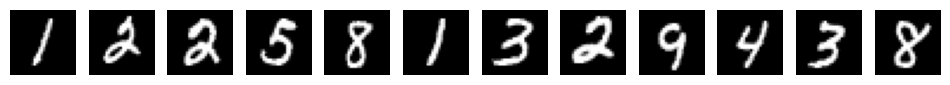

In [7]:
# your code here

X_train = X[:,:,:7000]
y_train = y[:7000]
plt.figure(figsize=(12,4), dpi=100)
X_valid = X[:,:,7000:]
y_valid = y[7000:]
for  i in range(12):
  plt.subplot(1,12,i+1)
  plt.imshow(X_valid[:,:,i], cmap='gray')
  plt.axis('off')
plt.show()










<br>

_**(Problem 1b)**_ Your train set should now contain 7,000 images, $X_\text{train}$, with correct labels, $y_\text{train}$.

For each integer $k$ from 0 to 9, how many images in the train set display integer $k$? Let $z=\left( z^{[0]}, z^{[1]},\dots, z^{[9]}\right)\in\Z^{10}$ be a zero-based vector of positive integers, such that $z^{[k]}$ represents the number of such images showing the digit $k$.

For your information, those ten numbers should sum to 7,000 and should look well balanced.


In [11]:
# your code here
z = {i:0 for i in range(10)}
for i in y_train:
  z[i] += 1
display(z)
sum = 0
for j in z:
  sum +=z[j]
print(sum)

{0: 672,
 1: 795,
 2: 729,
 3: 702,
 4: 700,
 5: 633,
 6: 656,
 7: 712,
 8: 682,
 9: 719}

7000


<br>

_**(Problem 1c)**_ The training process using the train set $X_\text{train}$ and $y_\text{train}$ is as follows:

- For each $k$ in $0,1,\dots,9$, construct a representative image $X^{[k]}_{\text{rep}}\in\R^{m\times m}$ that captures the representative characteristics or features of the images displaying $k$.
- The average image can be a good candidate for $X^{[k]}_{\text{rep}}$. For example,
$$
  X^{[k]}_{\text{rep}} = \frac{1}{z^{[k]}}\sum_{n: \ y^{(n)}_\text{train}=k} X^{(n)}
$$

Compute and display all ten representative images, $X^{[0]}_{\text{rep}}, X^{[1]}_{\text{rep}}, \dots, X^{[9]}_{\text{rep}}$. How do they look?

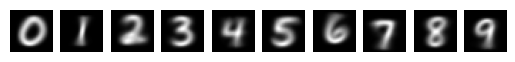

In [16]:
# your code here
X_rep = {i:np.zeros_like(X_train[:,:,0]) for i in range(10)}

for i in range(len(y_train)):

  X_rep[y_train[i]] += X_train[:,:,i]

for j in range(10):
  X_rep[j] = 1/z[j] * X_rep[j]


for  i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(X_rep[i], cmap='gray')
  plt.axis('off')
plt.show()


<br>

_**(Problem 1d)**_ Now we will use the representative images obtained above to build the classifier.

- The classifier compares the input image $X_\text{in}\in\R^{m\times m}$ with the ten representative images, $X^{[0]}_{\text{rep}}, X^{[1]}_{\text{rep}}, \dots, X^{[9]}_{\text{rep}}$, and chooses the closest one.
- In other words, your classifier computes
$$
y_\text{pred} = \underset{k}{\arg\min} \ \ \|X_\text{in}-X^{[k]}_\text{rep}\|^2_F,
$$
where $y_\text{pred}\in\ \{0,1,\dots,9\}$ is the prediction (which digit your input image look like) from your classifier, and the Frobenius norm $\|A\|_F^2$ for matrix $A$ is the square sum of all of its elements, so $\|X_\text{in}-X^{[3]}_\text{rep}\|^2_F$ being small implies that $X_\text{in}$ and $X^{[3]}_\text{rep}$ are close to each other. The $\arg\min$ function returns the index that achieves the smallest value.


Build the classfier function `ee370_digit_classifier()` that receives an $m\times m$ image `X_in` and returns the prediction label `y_pred` obtained from the above solution.

The Frobenius norm of `A` can be computed from `np.linalg.norm(A, 'fro')` and you may find `np.argmin()` function useful.


In [18]:
# your code
def classifier(X_input,X_rep ):
  rmse = np.linalg.norm(X_input - X_rep[0])
  answer = 0
  for i in range(1,len(X_rep)):
    if rmse > np.linalg.norm(X_input - X_rep[i]):
      answer = i
      rmse = np.linalg.norm(X_input - X_rep[i])
    else:
      continue
  return answer, rmse


accurate = {i: 0 for i in range(10)}


probab = {i: 0 for i in range(10)}
for i in range(len(y_train)):
  answer, _ = classifier(X_train[:,:,i],X_rep)
  if answer == y_train[i]:
    accurate[y_train[i]] +=1

for j in range(10):
  probab[j] = accurate[j]/z[j]
print(probab)




{0: 0.8973214285714286, 1: 0.9685534591194969, 2: 0.7846364883401921, 3: 0.8062678062678063, 4: 0.8085714285714286, 5: 0.7093206951026856, 6: 0.8460365853658537, 7: 0.8230337078651685, 8: 0.7419354838709677, 9: 0.7524339360222532}


<br>

_**(Problem 1e)**_ Run your classifier function on the first 12 images from the validation set, and display the images along with the predictions, $y_\text{pred}$, from your classifier. Do they look all correct? For which one among the twelve samples did your classifier make wrong answer?

In [20]:
# your code here

accurate = {i: 0 for i in range(10)}


# your code here
z = {i:0 for i in range(10)}
for i in y_valid:
  z[i] += 1
display(z)
sum = 0
for j in z:
  sum +=z[j]
print(sum)


probab = {i: 0 for i in range(10)}
for i in range(len(y_valid)):
  answer, _ = classifier(X_valid[:,:,i],X_rep)
  if answer == y_valid[i]:
    accurate[y_valid[i]] +=1








for j in range(10):
  probab[j] = accurate[j]/z[j]

print(probab)


{0: 308,
 1: 340,
 2: 303,
 3: 308,
 4: 282,
 5: 259,
 6: 302,
 7: 316,
 8: 292,
 9: 290}

3000
{0: 0.9253246753246753, 1: 0.8558823529411764, 2: 0.7887788778877888, 3: 0.7597402597402597, 4: 0.8829787234042553, 5: 0.6563706563706564, 6: 0.9337748344370861, 7: 0.9367088607594937, 8: 0.8287671232876712, 9: 0.7}


<br>

_**(Problem 1f)**_ A more sophisticated way to analyze the accuracy of your predictor is to build and check the _confusion matrix_ from the validation set. Note that the validation set contains the correct label $y_\text{valid}$ with which we can compare $y_\text{pred}$ to check if your classifier works properly.

For our problem, the confusion matrix $C$ is a 10x10 matrix each of whose element (with zero-based indices) is defined as follows.

$$
  C_{ij} = \text{# of occurrences for which the prediction was $i$ while the image was $j$}
$$

so the elements of $C$ sum to 3,000 ($n_\text{valid}$).

Compute and print the confusion matrix.

What is the accuracy (in percent) of your classifier? For which input digit does your classifier achieve the lowest accuracy?


{0: 308,
 1: 340,
 2: 303,
 3: 308,
 4: 282,
 5: 259,
 6: 302,
 7: 316,
 8: 292,
 9: 290}

3000


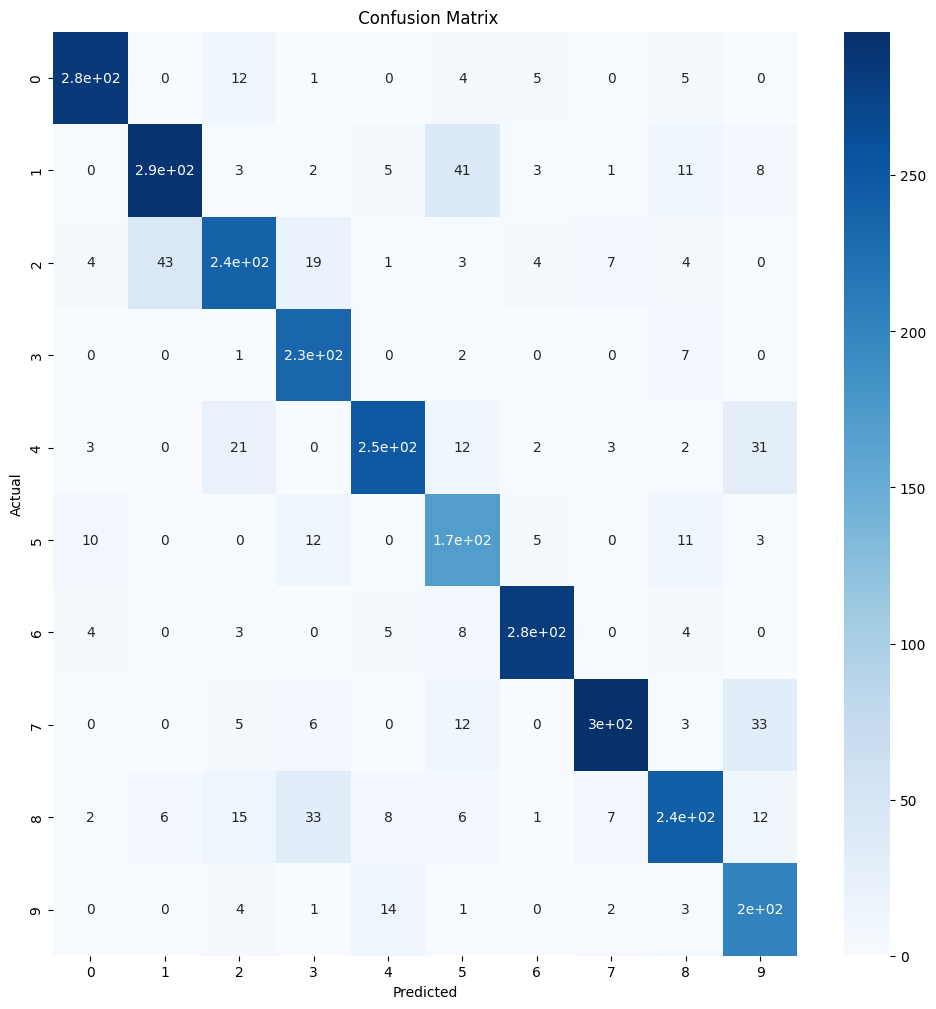

In [33]:
# your code here
import seaborn as sns
C = np.zeros([10,10])

accurate = {i: 0 for i in range(10)}


# your code here
z = {i:0 for i in range(10)}
for i in y_valid:
  z[i] += 1
display(z)
sum = 0
for j in z:
  sum +=z[j]
print(sum)


probab = {i: 0 for i in range(10)}
for i in range(len(y_valid)):
  answer, _ = classifier(X_valid[:,:,i],X_rep)
  if answer == y_valid[i]:
    C[y_valid[i]][y_valid[i]] +=1
  else:
    C[answer][y_valid[i]] +=1


plt.figure(figsize=(12,12))
sns.heatmap(C,annot=True,cmap="Blues",xticklabels=[i for i in range(10)],yticklabels=[i for i in range(10)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(' Confusion Matrix')
plt.show()



<br>

---
## Population dynamics



Suppose $x_t$ is a hundred dimensional vector, with $(x_t)_i$ denoting the number of people in some population (say, a country) with age  $i$ in year $t$, where $t$ is measured starting from some base year, for $i= 1, \dots, 100$. While $(x_t)_i$ is an integer, it is large enough that we simply consider it a real number. In any case, our model certainly is not accurate at the level of individual people.  Also, note that the model does not track people older than $100$ years old. The following cell downloads the population data from some country in 2010.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("https://jonghank.github.io/ee370/files/population_data.csv", \
                 header=None).values
x = data[:,0]   # population
b = data[:,1]   # birth rate
d = data[:,2]   # death rate
age = np.arange(100) + 1

The variable `x` displayed below represents the distribution (population) of ages from 1 to 100.

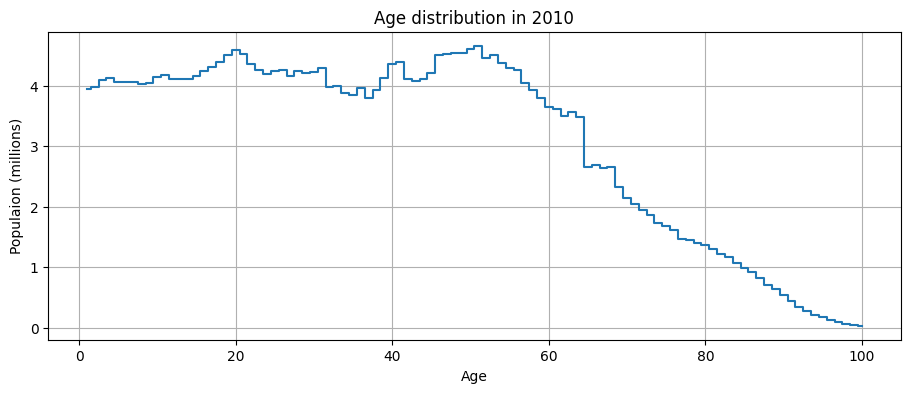

In [30]:
plt.figure(figsize=(11, 4), dpi=100)
plt.step(age, x, where="mid")
plt.title("Age distribution in 2010")
plt.xlabel("Age")
plt.ylabel("Populaion (millions)")
plt.grid()
plt.show()

The birth rate is given by a hundred dimensional vector $b$,  where $b_i$ is  the average number of births per person with age $i$, for $i=1,\dots,100$ (This is half the average number of births per woman with age $i$, assuming equal numbers of men and women in the population). Of course $b_i$ is approximately zero for $i<13$ and $i>50$.
The approximate birth rates for the country in year 2010 are shown in below.

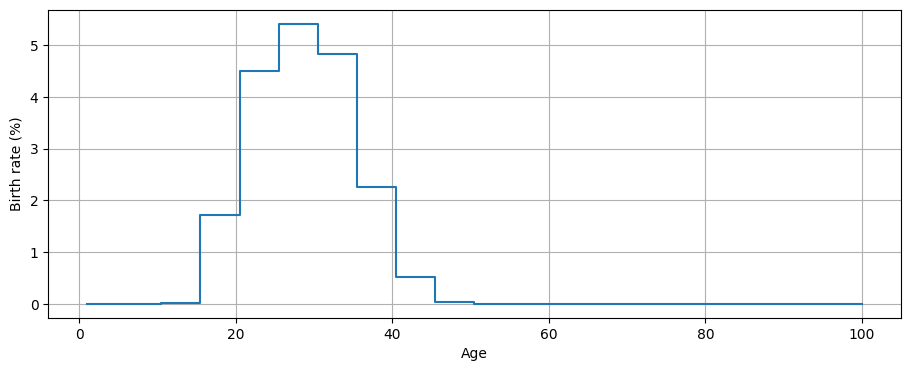

In [31]:
plt.figure(figsize=(11, 4), dpi=100)
plt.step(age, b*100, where="mid")
plt.xlabel("Age")
plt.ylabel("Birth rate (%)")
plt.grid()
plt.show()

The death rate is given by a hundred dimensional vector $d$, where $d_i$ is the portion of those aged $i$ who will die this year. The death rates for this country in year 2010 are shown below.

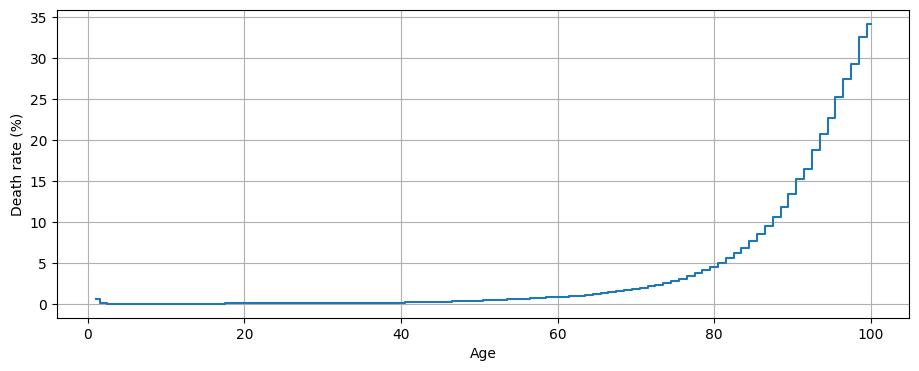

In [32]:
plt.figure(figsize=(11, 4), dpi=100)
plt.step(age, d*100, where="mid")
plt.xlabel("Age")
plt.ylabel("Death rate (%)")
plt.grid()
plt.show()

<br>

To derive the dynamical relations, we would like to find $x_{t+1}$ in terms of $x_t$, taking into account only births and deaths, and not immigration. The number of 1-year olds next year is the total number of births this year, so

$$
  (x_{t+1})_1 = b^T x_t
$$

The number of $i+1$ year olds next year is the number of $i$ year olds this year, minus those who die, so

$$
  (x_{t+1})_{i+1} = (1-d_i)(x_t)_i, \quad \text{for }i=1,\dots,99
$$

<br>

_**(Problem 2a)**_ Predict the total population of this country over the next 50 years. Display and explain how it changes.

In [51]:
# your code here
x = data[:,0]   # population
b = data[:,1]   # birth rate
d = data[:,2]   # death rate
print((1-d[0])*x[0])

3.9195779455000004


[3.94415 3.97807 4.09693 4.11904 4.06317 4.05686 4.06638 4.03058 4.04649
 4.14835 4.17254 4.11442 4.10624 4.11801 4.16598 4.24282 4.31614 4.39529
 4.50085 4.58523 4.51913 4.35429 4.26464 4.19857 4.24936 4.26235 4.15231
 4.24887 4.21525 4.22308 4.28567 3.97022 3.98685 3.88015 3.83922 3.95643
 3.80209 3.93445 4.12188 4.3648  4.38327 4.11498 4.0761  4.10511 4.2115
 4.50887 4.51976 4.53526 4.5388  4.6059  4.66029 4.46463 4.50085 4.38035
 4.292   4.25471 4.03751 3.93639 3.79493 3.64127 3.62113 3.4926  3.56318
 3.48388 2.65713 2.68076 2.63914 2.64936 2.32367 2.14232 2.04312 1.94932
 1.86427 1.73696 1.68449 1.62008 1.47107 1.45533 1.40012 1.37119 1.30851
 1.21287 1.16142 1.07481 0.98572 0.91472 0.81421 0.71291 0.64062 0.538
 0.43556 0.34499 0.28139 0.21698 0.16944 0.12972 0.09522 0.06814 0.0459
 0.03227]


array([[0.99377, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.99956, 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.99973, ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.72578, 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.70761, 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.6744 ]])

[4.02676618 3.91957795 3.97631965 4.09582383 4.11821619 4.06251989
 4.05637318 4.0659327  4.03013664 4.04600442 4.14789368 4.17212275
 4.11388513 4.10570619 4.1173923  4.1651468  4.2417593  4.31454303
 4.39322421 4.49796946 4.58197449 4.51569546 4.35050177 4.26092976
 4.19487526 4.2453656  4.25842864 4.14836531 4.24491855 4.2110769
 4.21881469 4.28125576 3.96589246 3.98246447 3.87572663 3.8348049
 3.95168228 3.79710926 3.9290598  4.11586206 4.35799091 4.3761691
 4.10736729 4.06790704 4.09624296 4.20126605 4.49723712 4.50629112
 4.52052041 4.52286881 4.58807517 4.641043   4.44436058 4.4786158
 4.35700273 4.26749268 4.22909665 4.01045868 3.90844163 3.76574699
 3.61112028 3.58998828 3.46004897 3.52761946 3.44552248 2.62391588
 2.64639266 2.60208647 2.6092222  2.28446969 2.10311554 2.00293183
 1.907741   1.82051558 1.69245908 1.63732428 1.57013293 1.42045048
 1.4013227  1.34235105 1.31019947 1.24355556 1.14568913 1.09000428
 1.00169068 0.9100857  0.83641082 0.73653437 0.63708489 0.56501403

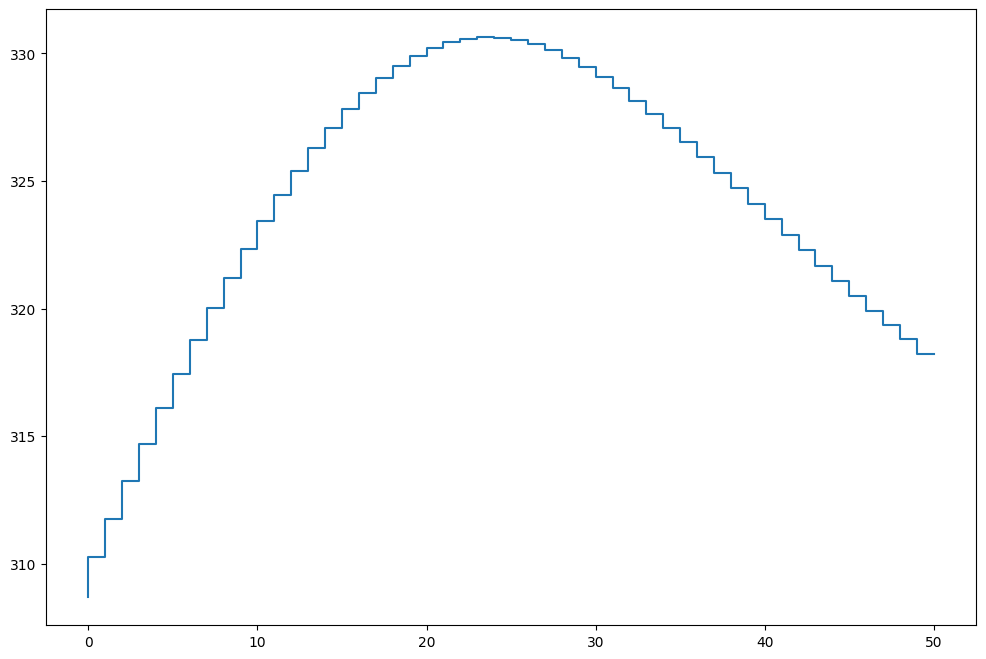

In [50]:
# your code here
x = data[:,0]   # population
b = data[:,1]   # birth rate
d = data[:,2]   # death rate

x_t = np.zeros_like(x)

x_t = x.copy()
print(x_t)
X = []
X.append(np.sum(x_t))

A = np.zeros([99,99])
for i in range(99):
  A[i,i] = 1-d[i]
display(A)


for i in range(50):

  x_t[0], x_t[1:] = np.dot(b,x_t) , A @x_t[:99]
  if i == 0:
    print(x_t)
  X.append(np.sum(x_t))

plt.figure(figsize=(12,8))

plt.step(range(51),X)




<br>

_**(Problem 2b)**_ Your data was originated from the United States Census Bureau. Google the current US population and check if your prediction was acceptable.

In [ ]:
# your answer here


<br>

_**(Problem 2c)**_ Predict the number of elementary school students (ages from 8 to 13) in this country over the next 50 years. Do we need to construct more elementary schools, or do we need to close some? Justify your answer by presenting appropriate computational results.

[3.94415 3.97807 4.09693 4.11904 4.06317 4.05686 4.06638 4.03058 4.04649
 4.14835 4.17254 4.11442 4.10624 4.11801 4.16598 4.24282 4.31614 4.39529
 4.50085 4.58523 4.51913 4.35429 4.26464 4.19857 4.24936 4.26235 4.15231
 4.24887 4.21525 4.22308 4.28567 3.97022 3.98685 3.88015 3.83922 3.95643
 3.80209 3.93445 4.12188 4.3648  4.38327 4.11498 4.0761  4.10511 4.2115
 4.50887 4.51976 4.53526 4.5388  4.6059  4.66029 4.46463 4.50085 4.38035
 4.292   4.25471 4.03751 3.93639 3.79493 3.64127 3.62113 3.4926  3.56318
 3.48388 2.65713 2.68076 2.63914 2.64936 2.32367 2.14232 2.04312 1.94932
 1.86427 1.73696 1.68449 1.62008 1.47107 1.45533 1.40012 1.37119 1.30851
 1.21287 1.16142 1.07481 0.98572 0.91472 0.81421 0.71291 0.64062 0.538
 0.43556 0.34499 0.28139 0.21698 0.16944 0.12972 0.09522 0.06814 0.0459
 0.03227]


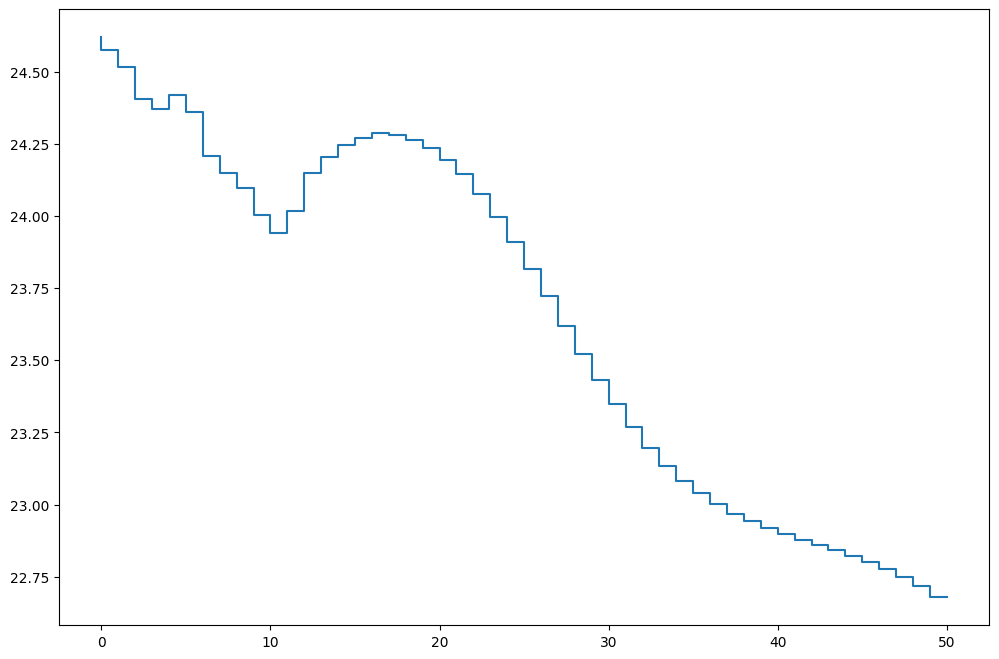

In [56]:
# your code here
# your code here
x = data[:,0]   # population
b = data[:,1]   # birth rate
d = data[:,2]   # death rate

x_t = np.zeros_like(x)

x_t = x.copy()
print(x_t)




A = np.zeros([99,99])
for i in range(99):
  A[i,i] = 1-d[i]
B = np.zeros([6,100])
for i in range(8,14):
  B[i-8][i-1] = 1


X = []
X.append(np.sum(B@x_t))



for i in range(50):
  x_t[0], x_t[1:] = np.dot(b,x_t) , A @x_t[:99]
  X.append(np.sum(B@x_t))

plt.figure(figsize=(12,8))

plt.step(range(51),X)




<br>

_**(Problem 2d)**_ The country is now in need of population growth, and two political parties claim the following different policies. Both look positive for increasing the population growth rate in the long run.

- Party D: We should support the birth promotion campaigns and the children welfare programs, which is expected to  increase the birth rate over the entire age band by a factor of 1.01 every year.

- Party R: We should support the public health and the disease control systems, which is expected to decrease the death rate over the entire age band by a factor of 0.99 every year.

Which party would you vote for, if the budgets and efforts accompanying these two policies are similar? Justify your answer by presenting appropriate computational results.





[3.94415 3.97807 4.09693 4.11904 4.06317 4.05686 4.06638 4.03058 4.04649
 4.14835 4.17254 4.11442 4.10624 4.11801 4.16598 4.24282 4.31614 4.39529
 4.50085 4.58523 4.51913 4.35429 4.26464 4.19857 4.24936 4.26235 4.15231
 4.24887 4.21525 4.22308 4.28567 3.97022 3.98685 3.88015 3.83922 3.95643
 3.80209 3.93445 4.12188 4.3648  4.38327 4.11498 4.0761  4.10511 4.2115
 4.50887 4.51976 4.53526 4.5388  4.6059  4.66029 4.46463 4.50085 4.38035
 4.292   4.25471 4.03751 3.93639 3.79493 3.64127 3.62113 3.4926  3.56318
 3.48388 2.65713 2.68076 2.63914 2.64936 2.32367 2.14232 2.04312 1.94932
 1.86427 1.73696 1.68449 1.62008 1.47107 1.45533 1.40012 1.37119 1.30851
 1.21287 1.16142 1.07481 0.98572 0.91472 0.81421 0.71291 0.64062 0.538
 0.43556 0.34499 0.28139 0.21698 0.16944 0.12972 0.09522 0.06814 0.0459
 0.03227]


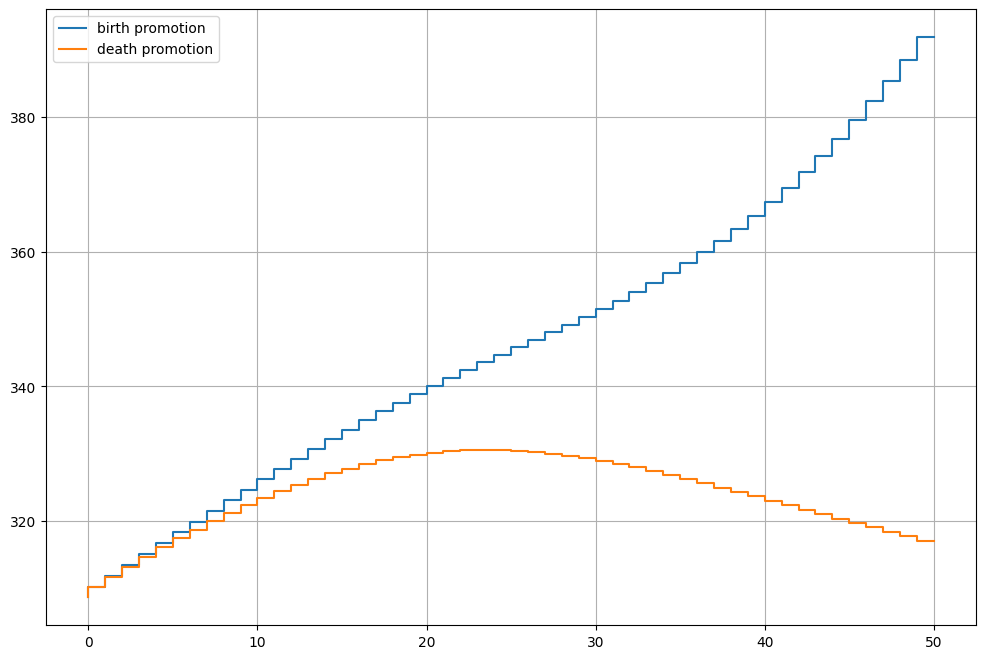

In [62]:
# your code and answer here
# your code here
# your code here
x = data[:,0]   # population
b = data[:,1]   # birth rate
d = data[:,2]   # death rate

b_d = b.copy()
b_r = b.copy()

d_d = d.copy()
d_r = d.copy()


x_t = np.zeros_like(x)

x_t = x.copy()
print(x_t)

x_t_d = x_t.copy()
x_t_r  = x_t.copy()

A_D = np.zeros([99,99])
for i in range(99):
  A_D[i,i] = 1-d[i]

X = [np.sum(x_t_d)]

for i in range(50):
  b_d= 1.01* b_d
  x_t_d[0], x_t_d[1:] = np.dot(b_d,x_t_d) ,A_D @x_t_d[:99]
  X.append(np.sum(x_t_d))


plt.figure(figsize=(12,8))

plt.step(range(51),X,label= "birth promotion")



X = [np.sum(x_t_r)]
A_R = np.zeros([99,99])




for i in range(99):
  A_R[i,i] = 1-d[i]



for i in range(50):
  d_r = 1.01*d_r
  for j in range(99):
    A_R[i,i] = 1-d_r[i]
  x_t_r[0], x_t_r[1:] = np.dot(b_r,x_t_r) ,A_R @x_t_r[:99]
  X.append(np.sum(x_t_r))


plt.step(range(51),X,label= "death promotion")
plt.legend()
plt.grid()
plt.show()







'''B = np.zeros([6,100])
for i in range(8,14):
  B[i-8][i-1] = 1
'''

X = []
X.append(np.sum(B@x_t))



